In [1]:
## import necessary libraries
import os
import sys
import json
import csv
import pandas as pd
import numpy as np
from collections import Counter
import random
import math
import nltk
from nltk.corpus import stopwords
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import gc

## garbage collection
gc.collect();
## load the dataframe of (mostly) raw tweets
input_file = '../../../tweet_data/cv_data/sentiment140/testdata.manual.2009.06.14.csv'
df = pd.read_csv(input_file)
df.columns = ['sentiment','?','date','query','screen_name','text']

## modify their sentiment scale to match mine:
df['sentiment'] = (df['sentiment'] - 2)/2

In [5]:
## manually inspect some cases
for i in range(1,10):
  print df['sentiment'].iloc[i], '||', df['text'].iloc[i]

1.0 || Ok, first assesment of the #kindle2 ...it fucking rocks!!!
1.0 || @kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
1.0 || @mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)
1.0 || @richardebaker no. it is too big. I'm quite happy with the Kindle2.
-1.0 || Fuck this economy. I hate aig and their non loan given asses.
1.0 || Jquery is my new best friend.
1.0 || Loves twitter
1.0 || how can you not love Obama? he makes jokes about himself.
0.0 || Check this video out -- President Obama at the White House Correspondents' Dinner http://bit.ly/IMXUM


In [6]:
## Preprocessing: set-up

## define a preprocessing function that 1) lowers the case, 2) tokenizes into words, 3) lemmatizes
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(sentence):
  return [wordnet_lemmatizer.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)]

## load the list of english stop words
stoplist = stopwords.words('english')

## set-up regular expressions to delete all non a-z characters
import re
regex = re.compile('[^a-zA-Z]')

## translation tables for dropping punctuation
## treat apostrophes differently from things like .,! also do not include _
import string
punctuation = string.punctuation
#punctuation = punctuation.replace('_', '')
punctuation_nospace = punctuation[6]
punctuation_space = [p for p in punctuation if p not in punctuation_nospace]
translate_table_nospace = dict((ord(char), None) for char in punctuation_nospace)   
translate_table_space = dict((ord(char), u' ') for char in punctuation_space)

## merge the tables
translate_table = translate_table_space.copy()
translate_table.update(translate_table_nospace) 

## load the list of emoticons
import codecs
f = codecs.open('../../emoticons_positive.txt', encoding='utf-8')
pos_emoticons = []
for line in f:
  pos_emoticons.append(line[0:-1])
f = codecs.open('../../emoticons_negative.txt', encoding='utf-8')
neg_emoticons = []
for line in f:
  neg_emoticons.append(line[0:-1])
all_emoticons = pos_emoticons + neg_emoticons
ASCII_all_emoticons = [e.encode("ascii","ignore") for e in all_emoticons]

## Preprocessing: implementation
words = []
new_text = []
for i in range(len(df)):
  text_dummy = df['text'].iloc[i]

  ## tokenize positive and negative emoticons
  ## also pad the token with spaces to catch even embedded tweets such as 'lame:('
  for j in range(len(pos_emoticons)):
    text_dummy = text_dummy.replace(pos_emoticons[j], ' posemoticontoken' + ' ')
  for j in range(len(neg_emoticons)):
    text_dummy = text_dummy.replace(neg_emoticons[j], ' negemoticontoken' + ' ')
  
  ## tokenize handles, hashtags, and url's
  text_dummy = text_dummy.replace('@', ' usernametoken') #this catches the '.@XXX' trick
  text_dummy = text_dummy.replace('#', ' hashtagtoken')
  while 'https://' in text_dummy:
    text_dummy = text_dummy[:text_dummy.index('https://')] +' urltoken ' + text_dummy[text_dummy.index('https://')+23:]
  while 'http://' in text_dummy:
    text_dummy = text_dummy[:text_dummy.index('http://')] +' urltoken ' + text_dummy[text_dummy.index('http://')+22:]
  
  ## replace html entities with space (note: 'and' is a stopword and so is dropped, so no need to treat & special)
  html_entities = [u'&nbsp;', u'&lt;', u'&gt;', u'&amp;', u'&quot;', u'&apos;', u'&cent;', u'&pound;', u'&yen;', u'&euro;', u'&copy;', u'&reg;']
  for html in html_entities:
    text_dummy = text_dummy.replace(html, '')
  
  ## drop punctuation, tokenize into words, lower the case, and lemmatize
  text_dummy = text_dummy.translate(translate_table)
  words_dummy = preprocess(text_dummy)

  ## remove stop words
  words_dummy = [w for w in words_dummy if not w in stoplist]
  
  ## anonymize the username_tokens
  for j in range(len(words_dummy)):
    if words_dummy[j][0:13] == 'usernametoken':
      words_dummy[j] = 'usernametoken'

  ## remove numbers
  words_dummy = [regex.sub('', w) for w in words_dummy if len(regex.sub('', w)) > 0]
  
  ## make a new sentence for easy vectorized manipulations
  words.append(words_dummy)
  new_text.append(" ".join(words_dummy))
df['words'] = words
df['new_text'] = new_text

In [7]:
## emoticon statistics
pos_emoticon_counter = 0
neg_emoticon_counter = 0
for i in range(len(df)):
  if df['sentiment'].iloc[i] == 1:
    pos_emoticon_counter += Counter(df['words'].iloc[i])['posemoticontoken']
  if df['sentiment'].iloc[i] == -1:
    neg_emoticon_counter += Counter(df['words'].iloc[i])['negemoticontoken']

print 'avg. positive emoticons per positive tweet:', float(pos_emoticon_counter)/sum(df['sentiment']==1)
print 'avg. negative emoticons per negative tweet:', float(neg_emoticon_counter)/sum(df['sentiment']==-1)

avg. positive emoticons per positive tweet: 0.110497237569
avg. negative emoticons per negative tweet: 0.0677966101695


number of tweets: 497
  number of neutral tweets: 139, 27.967806841%
  number of positive tweets: 181, 36.4185110664%
  number of negative tweets: 177, 35.6136820926%

training set statistics:
  total number of words: 4409
  total number of unique words: 1839
  lexical diversity: 0.417101383534


+------------------+-------+
| Word             | Count |
+------------------+-------+
| urltoken         |   130 |
| usernametoken    |   126 |
| time             |    50 |
| night            |    37 |
| new              |    36 |
| warner           |    36 |
| wa               |    34 |
| good             |    33 |
| love             |    32 |
| nike             |    27 |
| posemoticontoken |    26 |
| im               |    26 |
| museum           |    26 |
| got              |    23 |
| see              |    22 |
| gm               |    22 |
| get              |    21 |
| jquery           |    21 |
| hate             |    20 |
| kindle           |    20 |
+------------------+-------+


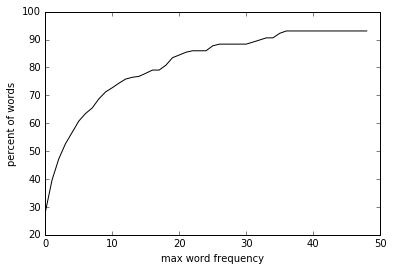

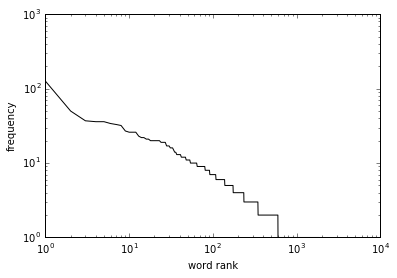

In [8]:
words_tot = [item for sublist in df['words'] for item in sublist]
count = Counter(words_tot).most_common()
words_unique = [count[i][0] for i in range(len(count))]
words_frequencies = [count[i][1] for i in range(len(count))]

## print out some preliminary statistics
print 'number of tweets: ' + str(len(df))
print '  number of neutral tweets: ' + str(sum(df['sentiment']==0)) + ', ' + str(float(sum(df['sentiment']==0))/len(df)*100) + '%'
print '  number of positive tweets: ' + str(sum(df['sentiment']==1)) + ', ' + str(float(sum(df['sentiment']==1))/len(df)*100) + '%'
print '  number of negative tweets: ' + str(sum(df['sentiment']==-1)) + ', ' + str(float(sum(df['sentiment']==-1))/len(df)*100) + '%'

if sum(df['sentiment']==-1) + sum(df['sentiment']==0) + sum(df['sentiment']==1) != len(df):
  print 'Warning: not all tweets classified as 1,0,-1!'

## lexical diversity
def lexical_diversity(tokens):
    return 1.0*len(set(tokens))/len(tokens) 

print '\ntraining set statistics:'
print '  total number of words:', len(words_tot)
print '  total number of unique words:', len(words_unique)
print '  lexical diversity:', lexical_diversity(words_tot)

## examine word frequencies
print '\n'
pt = PrettyTable(field_names=['Word', 'Count']) 
[ pt.add_row(kv) for kv in count[:20] ]
pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

## get a sense for the frequency distribution of words
## what % of words occur with frequency <= x
maxwordfreq = [100.0*c*words_frequencies.count(c)/len(words_tot) for c in range(1,50)]
for i in range(1,len(maxwordfreq)):
  maxwordfreq[i] += maxwordfreq[i-1]
%matplotlib inline
plt.plot(maxwordfreq, c='black')
plt.ylabel('percent of words')
plt.xlabel('max word frequency')
plt.show()

## plot frequency(rank)
words_tot_counts = sorted(Counter(words_tot).values(), reverse=True)
plt.loglog(words_tot_counts, c='black')
plt.ylabel('frequency')
plt.xlabel('word rank')
plt.show()

In [10]:
## save the processed data
output_file = '../../../tweet_data/cv_data/sentiment140/sentiment140_cv_data_processed.pkl'
df_final = df.copy(deep=True)
df_final = df_final.drop([l for l in list(df.columns.values) if l not in ['sentiment','words','text']], axis=1)
df_final.to_pickle(output_file)

In [8]:
## example for blog write-up
print df['text'].iloc[15]
print df['words'].iloc[15]
print df['sentiment'].iloc[15]
print len(df)

I was talking to this guy last night and he was telling me that he is a die hard Spurs fan.  He also told me that he hates LeBron James.
[u'wa', u'talking', u'guy', u'last', u'night', u'wa', u'telling', u'die', u'hard', u'spur', u'fan', u'also', u'told', u'hate', u'lebron', u'james']
-1.0
497
